In [66]:
import sys, os
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
import matplotlib.pyplot as plt

local_path = '\\Users\\frank\\Online dictionnary learning spard coding\\Online-Dictionary-Learning-for-Sparse-Coding'
sys.path.append(local_path)

%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import StandardScaler
from src.Visualization.Audio import AudioVisualizer
from src.Visualization.TimeseriesVisualyzation import TimeSeriesPlotter
from src.Evalution.Reconstruction import Evaluation
from src.Dataset.Audioselection import AudioPreprocessor, AudioSplitter
from src.Model.Audio_model import DictionaryLearner, DictionaryVisualizer
from src.Dataset.Noise import NoiseAdder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 I use this code to split the dataset into train and test

In [ ]:
'''base_path = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips'
splitter = AudioSplitter(base_path)
splitter.split()'''

## Signal Reconstruction : Reconstruct a signal which was part of train set

### Select video and preprocess them to learn the dictionnary

In [92]:
directory_path = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips\\train_set'
num_samples = 100 # Number of audio files to select

preprocessor = AudioPreprocessor(directory_path, num_samples, target_duration=3)
preprocessed_audios = preprocessor.preprocess_all()


### Use gridsearch to find suitable parameters

In [99]:
def calculate_L2_error(original_signal, reconstructed_signal):
    alignment = np.linalg.norm(original_signal - reconstructed_signal)
    return alignment

In [10]:
param_grid = {
    'n_components': [ 30, 40, 50],
    'alpha': [1, 2, 5 ,8],
    'batch_size': [3, 5, 10, 15, 20]
}


In [13]:
best_params = None
best_error = float('inf')

# Iterating over the parameter grid
for n_components in tqdm(param_grid['n_components']):
    for alpha in param_grid['alpha']:
            for batch_size in param_grid['batch_size']:
                # Initialize and train the DictionaryLearner
                learner = DictionaryLearner(n_components=n_components, alpha=alpha, max_iter= 2000, batch_size=batch_size)
                dictionary = learner.fit(preprocessed_audios)

                # Evaluate the dictionary using DTW error
                evaluator = Evaluation(dictionary)
                total_error = 0
                for signal in preprocessed_audios:
                    reconstructed_signal = evaluator.reconstruct_signal(signal)
                    total_error += calculate_L2_error(signal, reconstructed_signal)

                avg_error = total_error / len(preprocessed_audios)

                
                # Update best parameters
                if avg_error < best_error:
                    best_error = avg_error
                    best_params = {'n_components': n_components, 'alpha': alpha,  'batch_size': batch_size}

print(f"Best Parameters: {best_params}, Best Error: {best_error}")


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.702e-06, previous alpha=1.702e-06, with an active set of 6 regressors.
  warnings.warn(
 67%|██████▋   | 2/3 [21:09<11:29, 689.70s/it]C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.720e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

Best Parameters: {'n_components': 50, 'alpha': 1, 'batch_size': 3}, Best Error: 15.150465828180312


In [97]:
print(f"The best parameters are {best_params}")
print(f"The corresponding L2 norm between the reconstructed and original signals is {best_error}")

The best parameters are {'n_components': 50, 'alpha': 1, 'batch_size': 3}
The corresponding L2 norm between the reconstructed and original signals is 15.150465828180312


### use those parameters to learn dictionnary

In [93]:
learner = DictionaryLearner(n_components=best_params["n_components"], alpha=best_params["alpha"], max_iter=2000,
                             batch_size= best_params["batch_size"])
dictionary = learner.fit(preprocessed_audios)



#### Display some atoms, you can view all of them if you want, it just makes the notebook too long

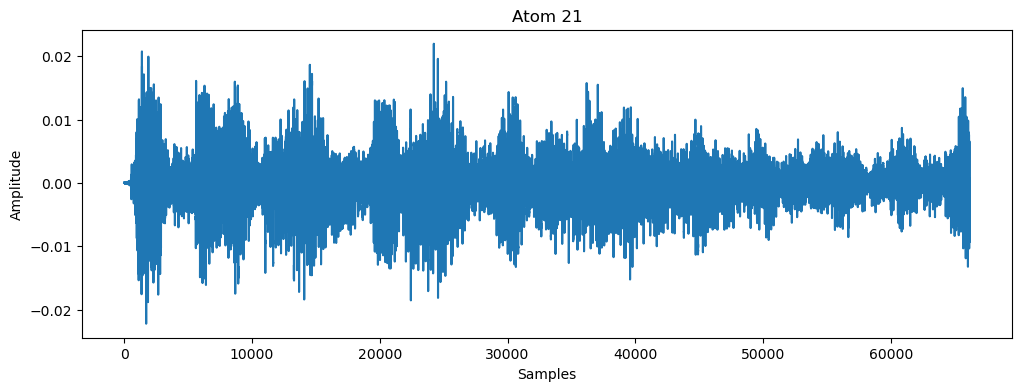

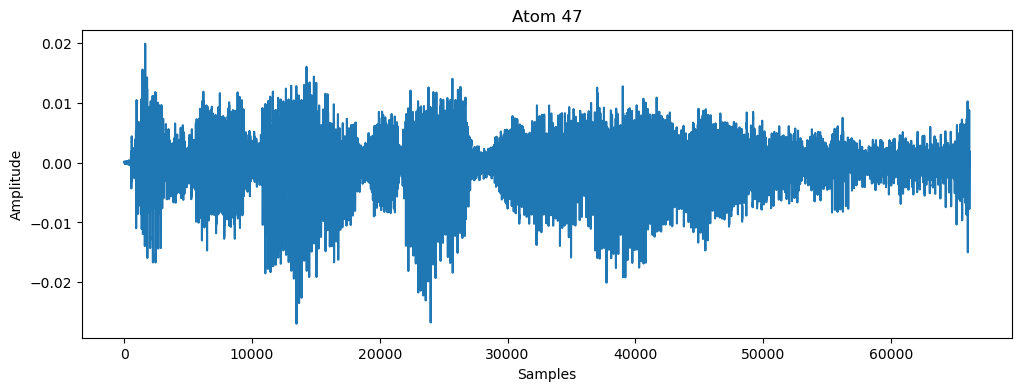

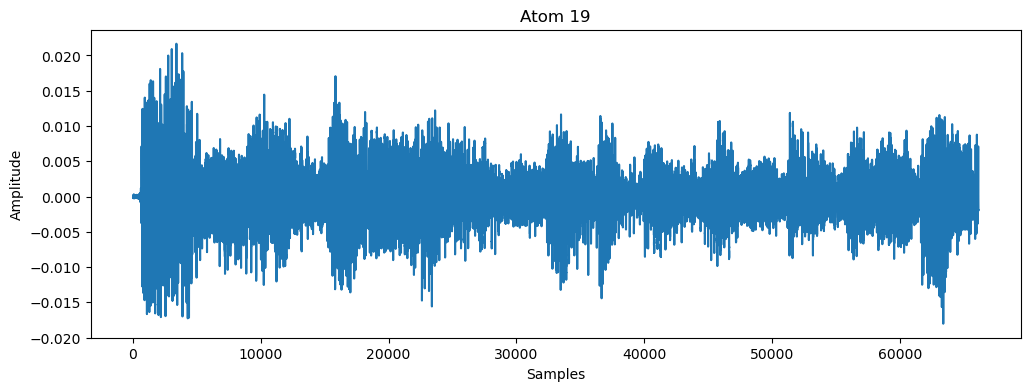

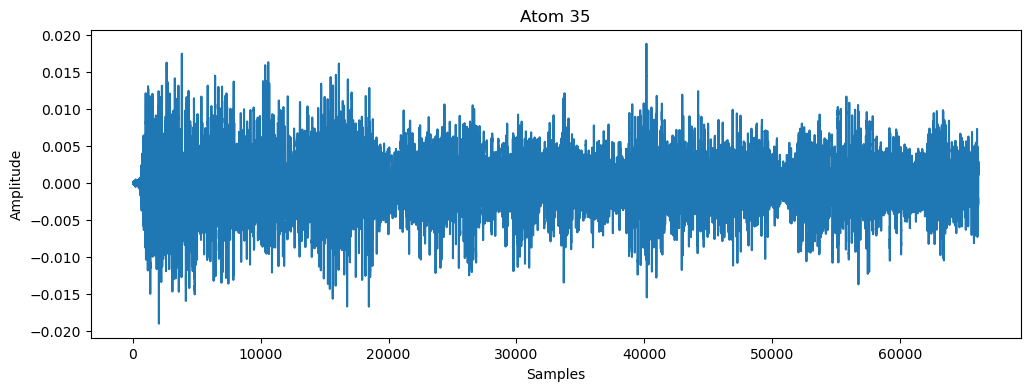

In [96]:
number_dic = 4
visualizer = DictionaryVisualizer(dictionary, sample_rate=22050, number_dic = number_dic)
visualizer.show_all_atoms()

In [100]:

Reconstructor = Evaluation(dictionary)
best_signal_reconstruted = []

for i in range(len(preprocessed_audios)):
   reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
   distance = calculate_L2_error(preprocessed_audios[i], reconstructed_signal)
   if distance <  3: 
      best_signal_reconstruted.append(i)

### Reconstruction of signal which was part off train set.
You can visualyse all of them and all the atoms to see that the dictionnary did'nt just memory those specifique signals 

The original signal 61


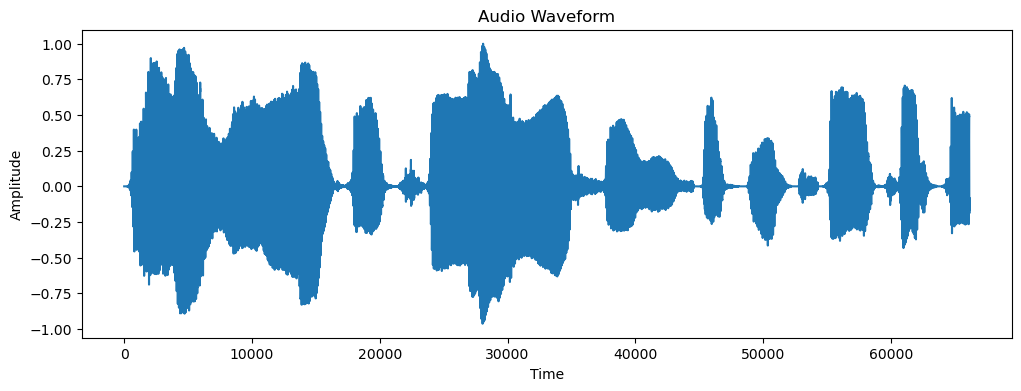

The reconstruction version of 61


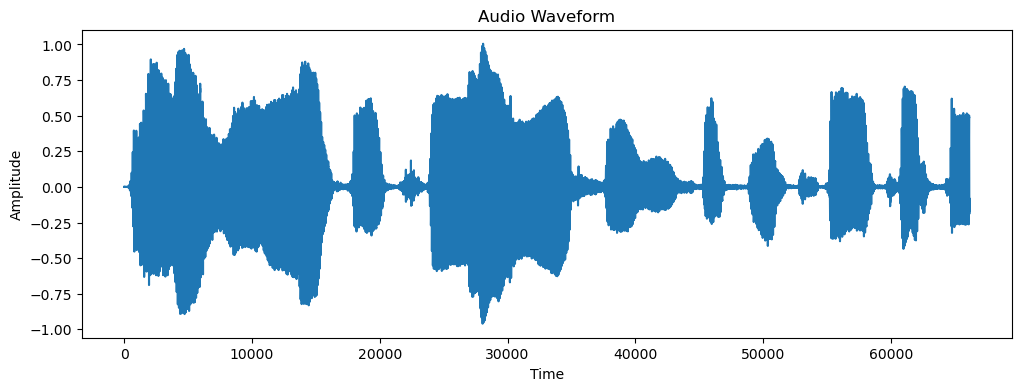



The original signal 0


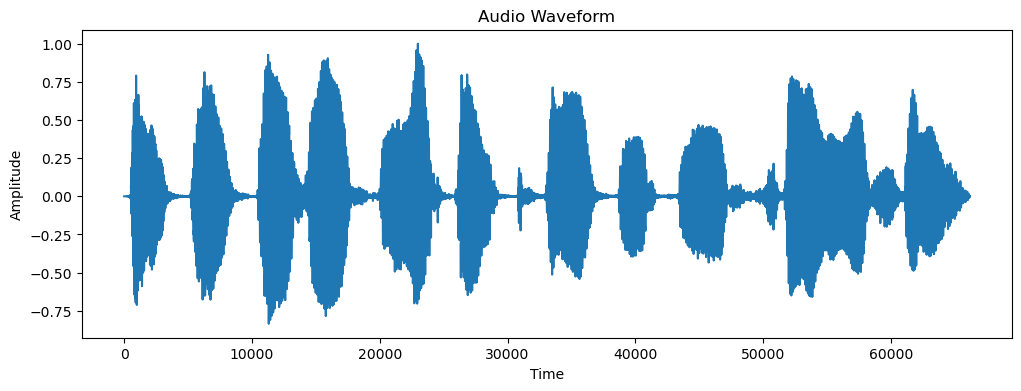

The reconstruction version of 0


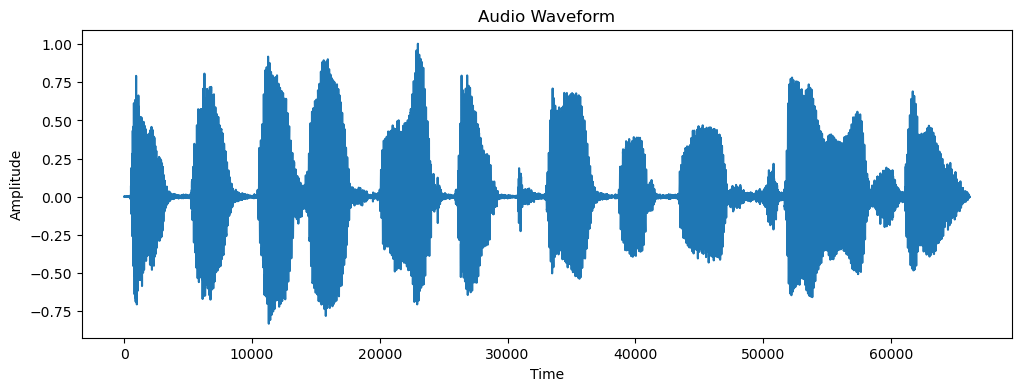



The original signal 79


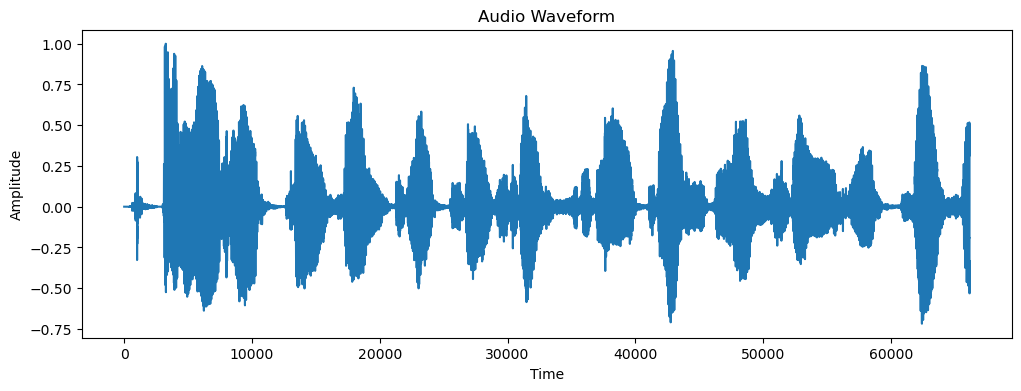

The reconstruction version of 79


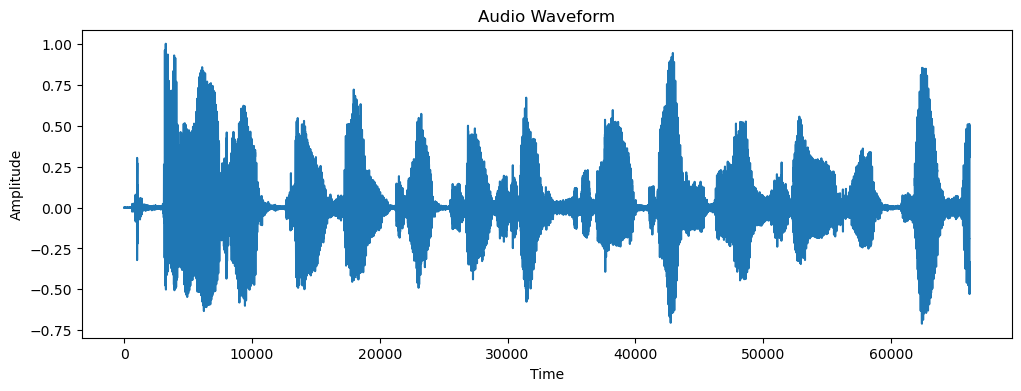



The original signal 27


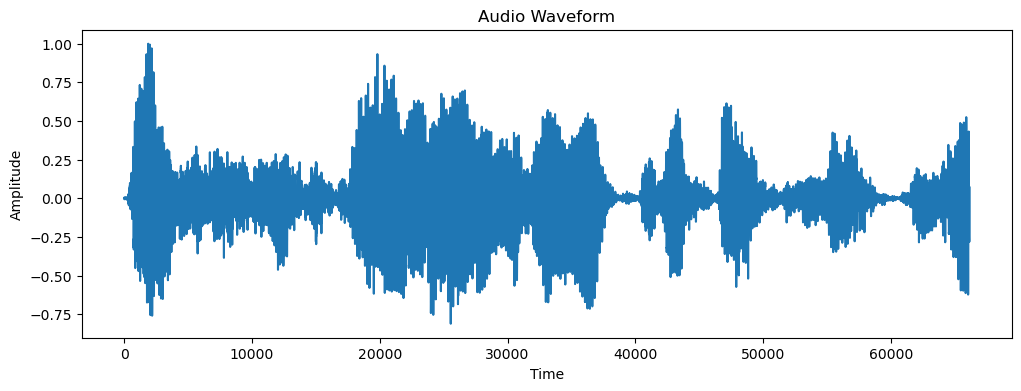

The reconstruction version of 27


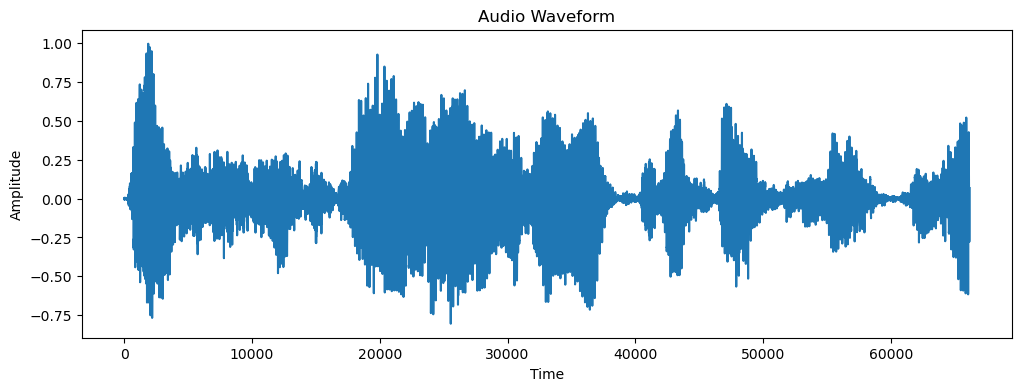

In [101]:

num_display = 4
for i in random.sample(best_signal_reconstruted, number_dic):
    reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
    print(f"The original signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f"The reconstruction version of {i}")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")
    

### Denoising of signal which was part of train set

##### Now we add noises (Dogs voice) to some of those signals (abritrary choising) and using the learned dictionnary to denoise them

In [102]:
noise_adder = NoiseAdder('C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\UrbanSound8K\\UrbanSound8K\\audio\\fold1')

Add different noises to different signals

Original Signal 18


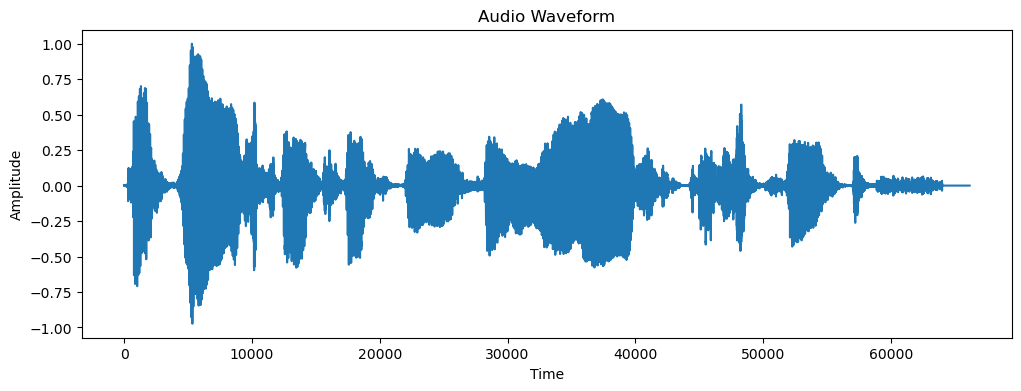

Noised Signal


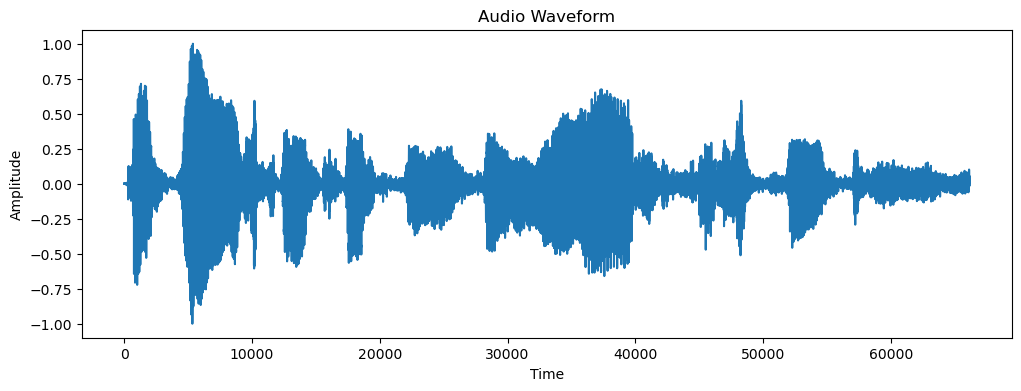

 Reconstructed signal


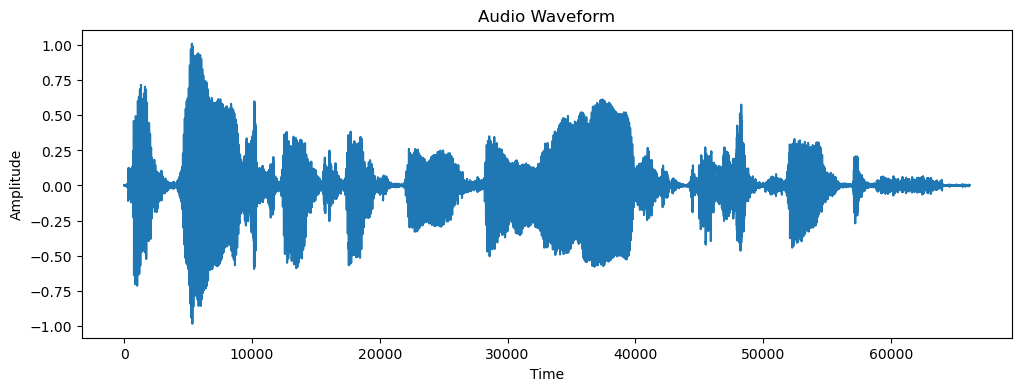



Original Signal 43


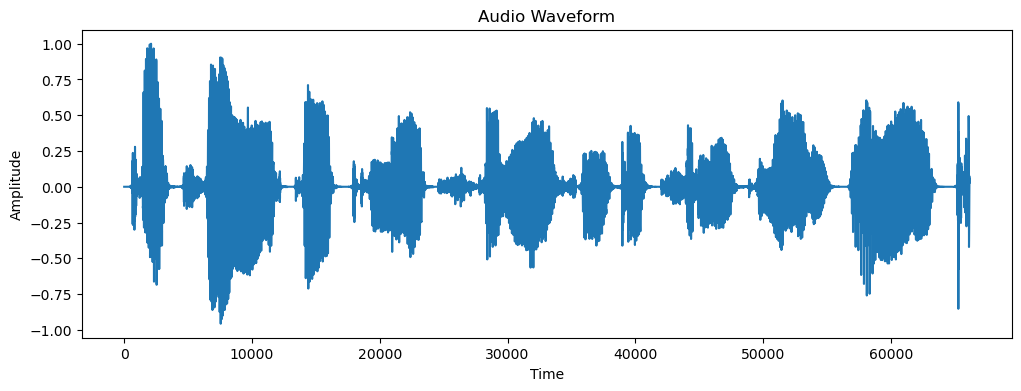

Noised Signal


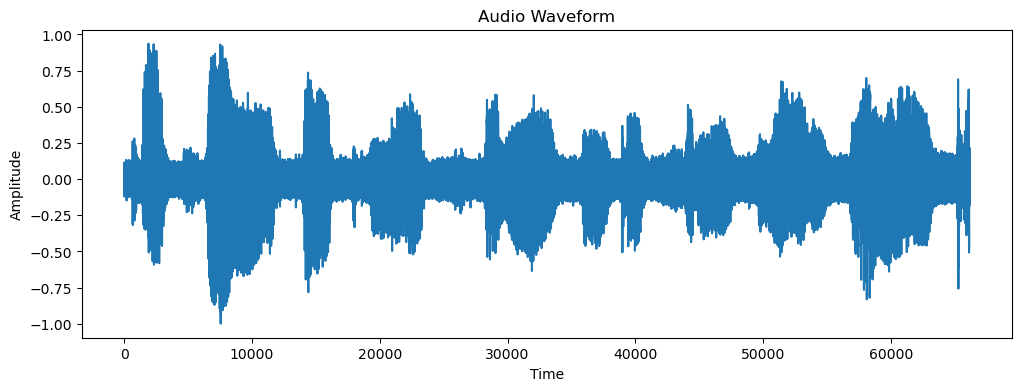

 Reconstructed signal


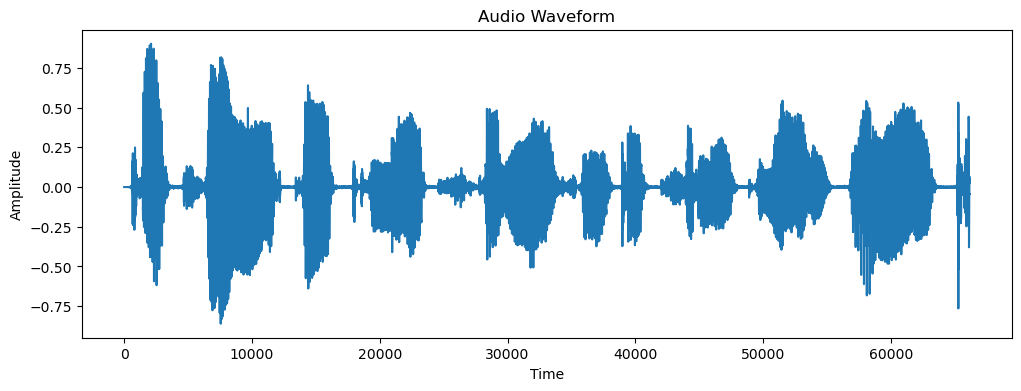

In [106]:
Num_Signal_Add_Noise = 2

for i in random.sample(best_signal_reconstruted, Num_Signal_Add_Noise):
    noised_signal = noise_adder.match_length_and_add_noise(preprocessed_audios[i], sr = None)
    reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)
    print(f"Original Signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f"Noised Signal")
    visualizer = AudioVisualizer(noised_signal)
    visualizer.show()
    print(f" Reconstructed signal")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

Note that the lenght of the signal (audio) doesn't have any impact on the previous resultats, to see that you can change the parameter **target_duration** when loading the train set

### Now we add different noises to the same signal

Original Signal 15


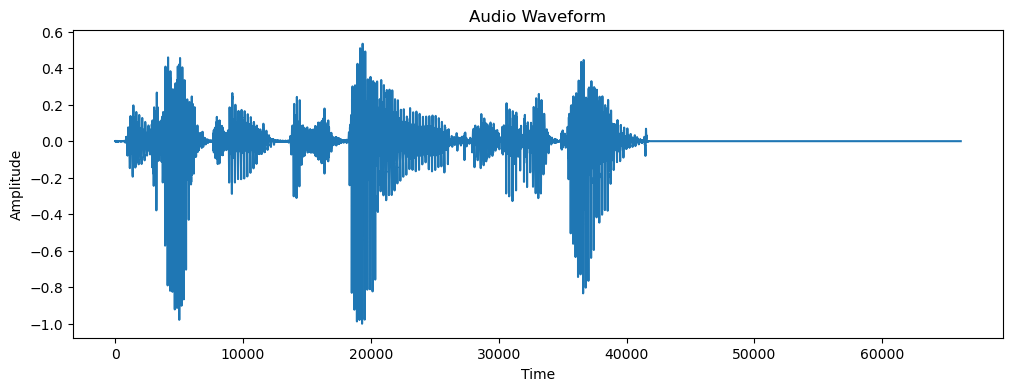

Noised version 0


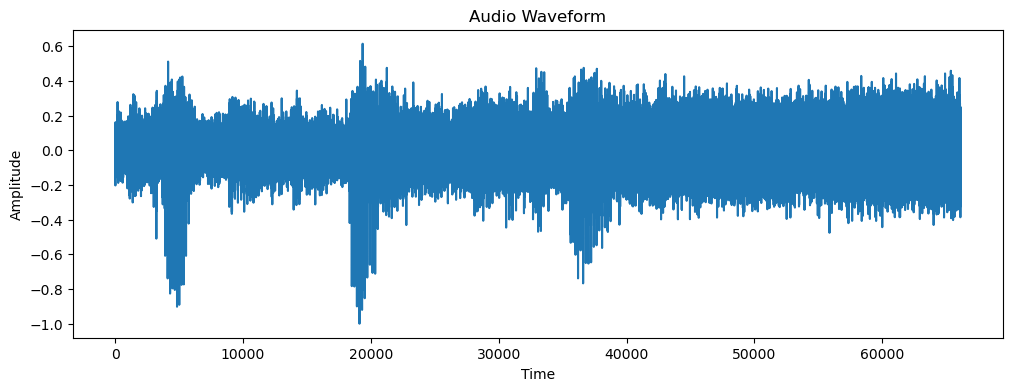

 Reconstructed of the noised version 0


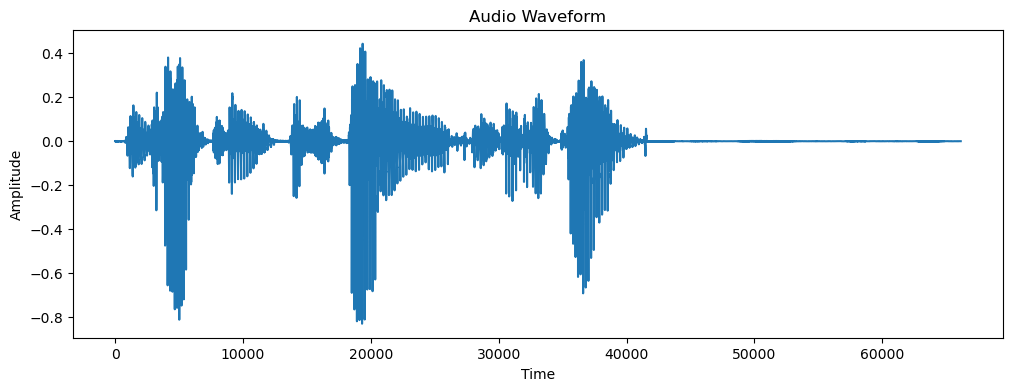



Noised version 1


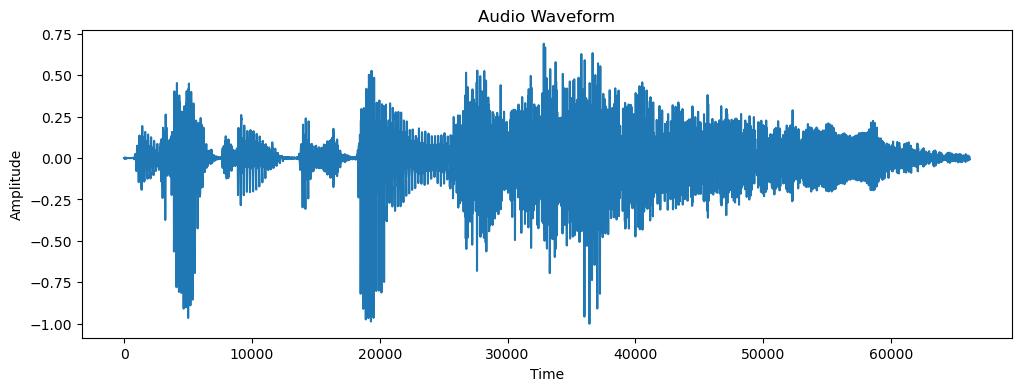

 Reconstructed of the noised version 1


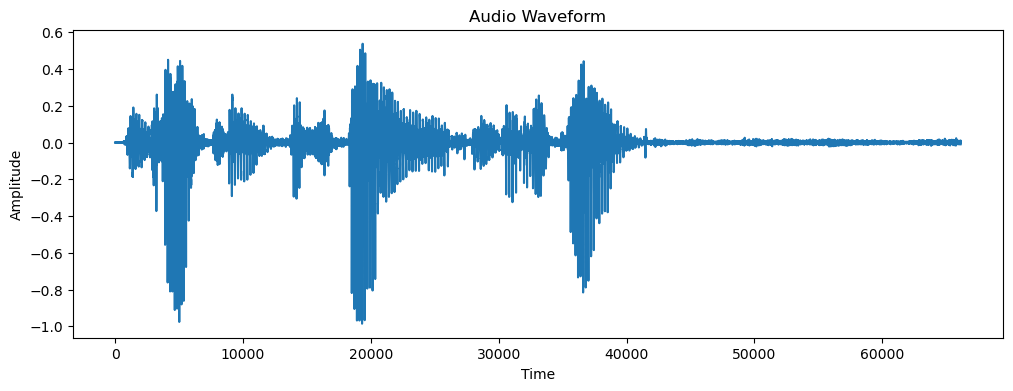



Noised version 2


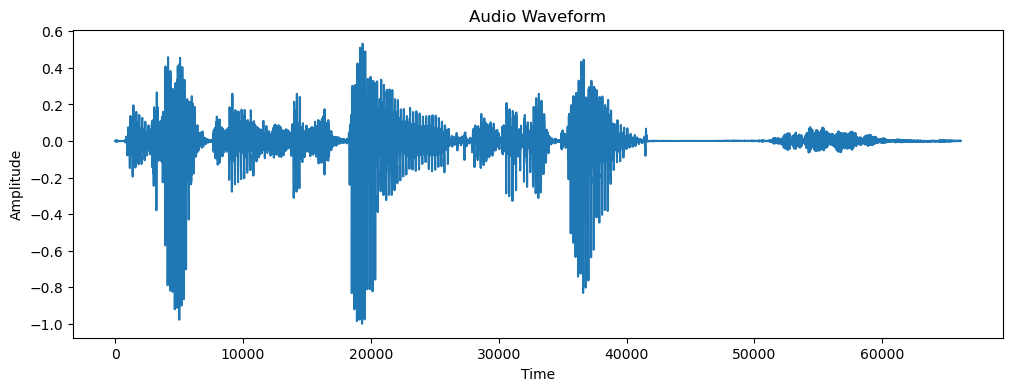

 Reconstructed of the noised version 2


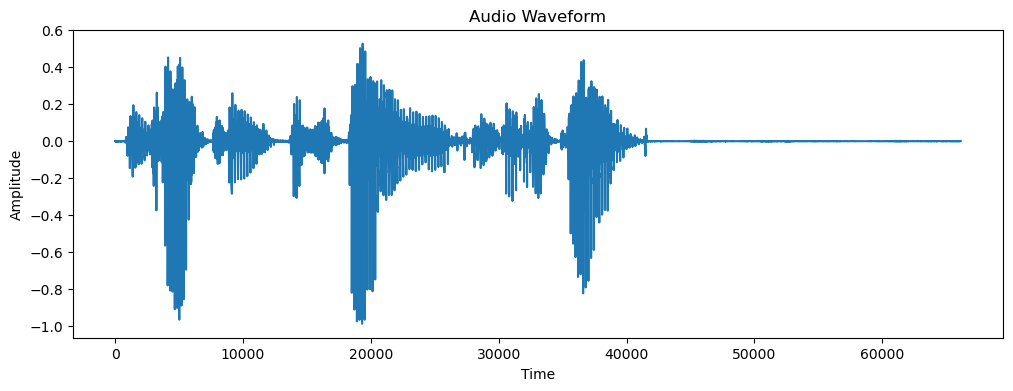

In [41]:
Num_Noise =  3
index_signal = random.sample(best_signal_reconstruted, 1)[0]

print(f"Original Signal {index_signal}")
visualizer = AudioVisualizer(preprocessed_audios[index_signal])
visualizer.show()
for i in range(Num_Noise):
    noised_signal = noise_adder.match_length_and_add_noise(preprocessed_audios[index_signal], sr = None)
    reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)
    print(f"Noised version {i}")
    visualizer = AudioVisualizer(noised_signal)
    visualizer.show()
    print(f" Reconstructed of the noised version {i}")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

### Add multi-noise to the same signal and denoise it

Original Signal


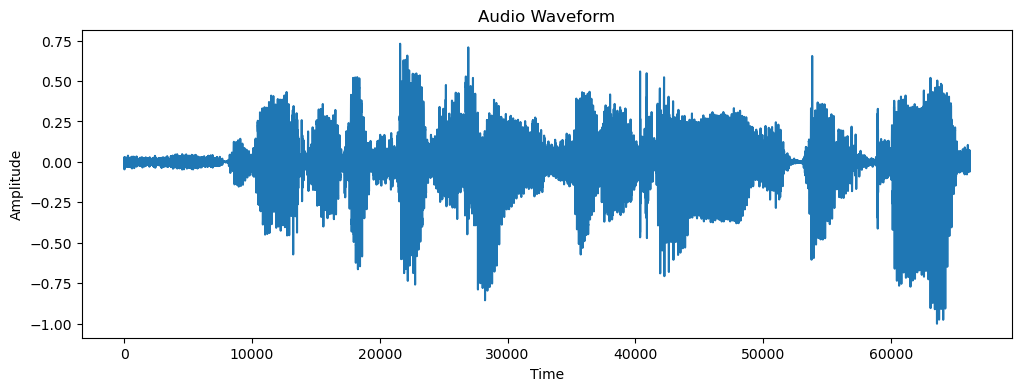

Signal with 3 different noises


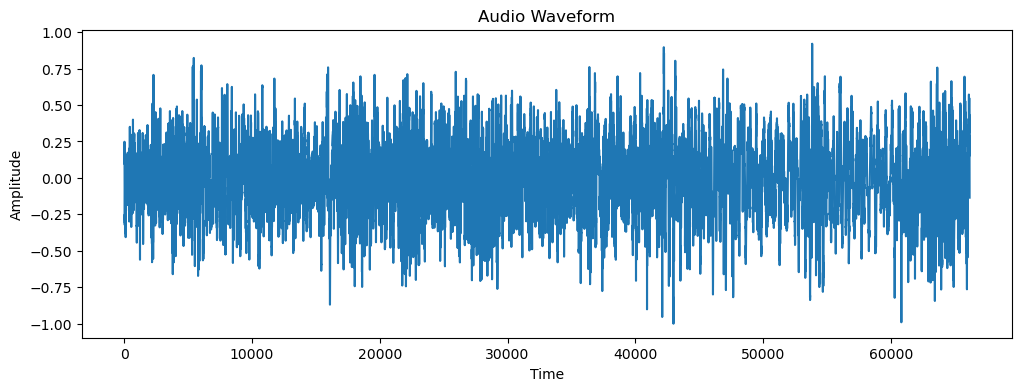

Denoised Version


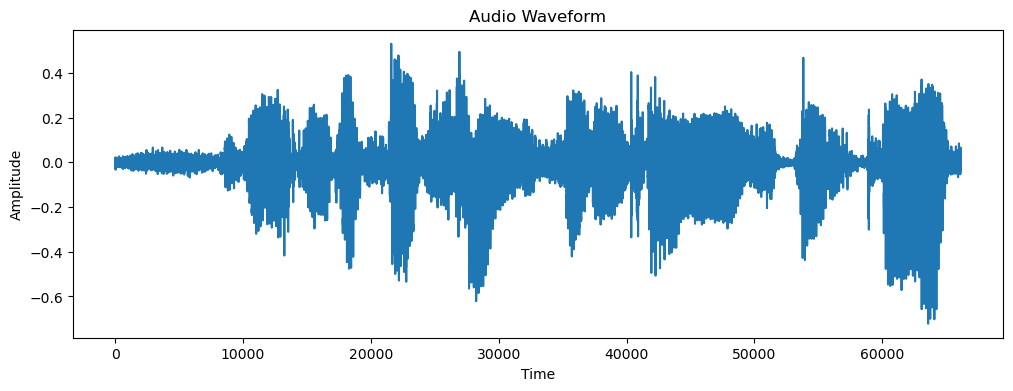

In [46]:
num_level_noise = 3
index_signal = random.sample(best_signal_reconstruted, 1)[0]
noised_signal = preprocessed_audios[index_signal]

for i in range(num_level_noise):
    noised_signal = noise_adder.match_length_and_add_noise(noised_signal, sr = None)

reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)

print(f"Original Signal")
visualizer = AudioVisualizer(preprocessed_audios[index_signal])
visualizer.show()
print(f"Signal with {num_level_noise} different noises")
visualizer = AudioVisualizer(noised_signal)
visualizer.show()
print("Denoised Version")
visualizer = AudioVisualizer(reconstructed_signal)
visualizer.show()



## Signal Reconstruction : Reconstruct a signal which was not part of train set

In [71]:

num_samples = 8000
preprocessor = AudioPreprocessor(directory_path, num_samples, target_duration= 1.5)
preprocessed_audios = preprocessor.preprocess_all()

C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1799
  warnings.warn(


In [72]:
learner = DictionaryLearner(n_components= 4000, alpha= 2, max_iter=20000,
                             batch_size= 5)
dictionary = learner.fit(preprocessed_audios)


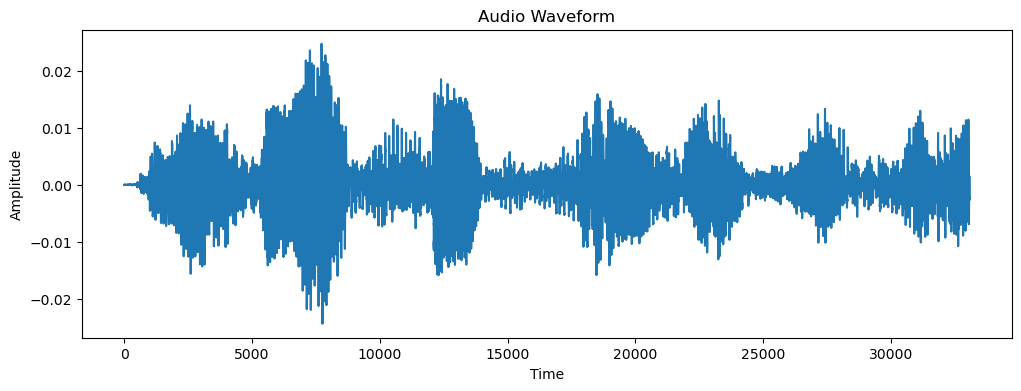

In [76]:
AudioVisualizer(dictionary[4]).show()

In [89]:
directory_path_test = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips\\test_set'
num_samples_test = 2
preprocessor = AudioPreprocessor(directory_path_test, num_samples_test, target_duration= 1.5)
preprocessed_audios = preprocessor.preprocess_all()

In [80]:
Reconstructor = Evaluation(dictionary)

Original Signal 0


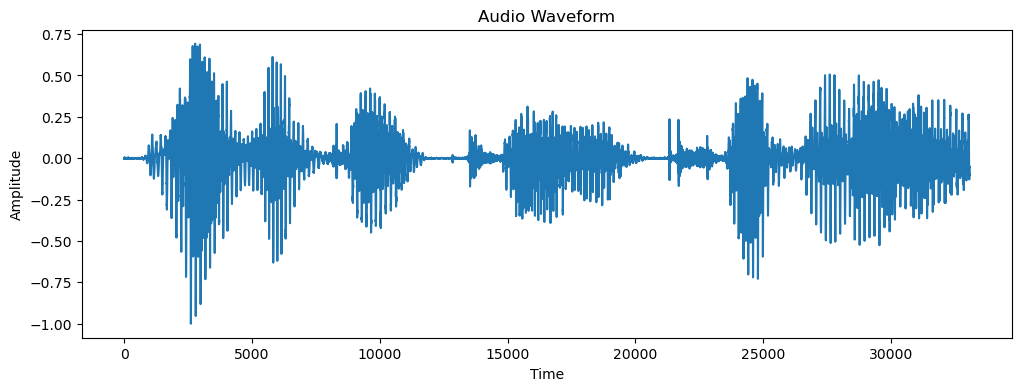

 Reconstructed signal


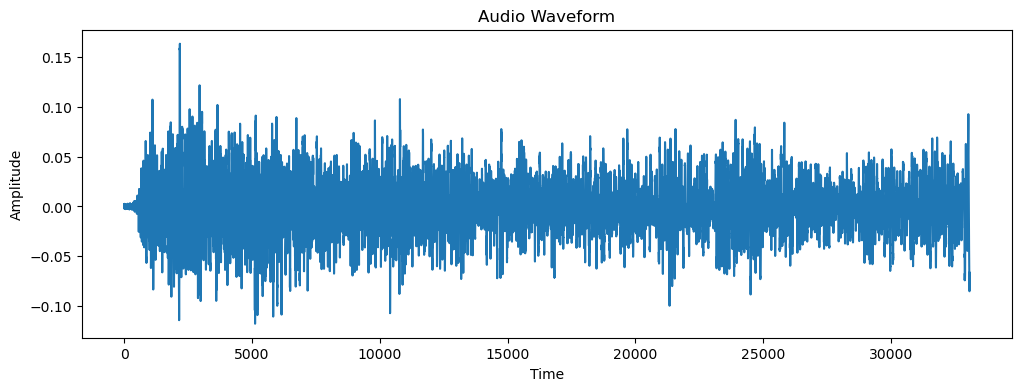



Original Signal 1


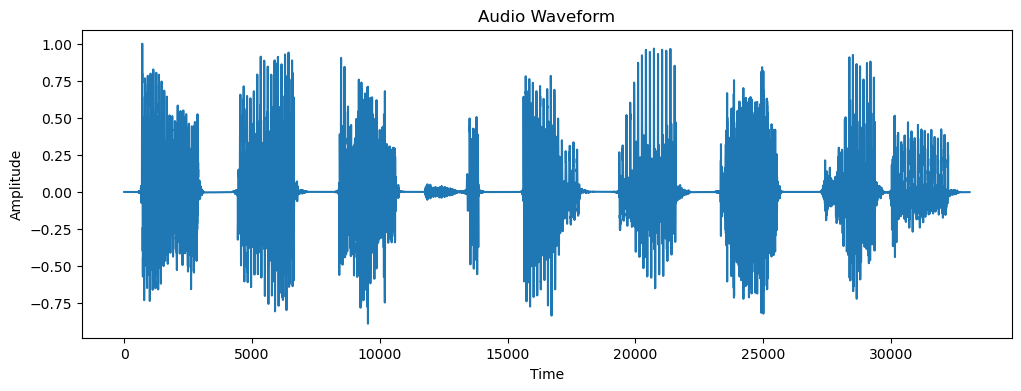

 Reconstructed signal


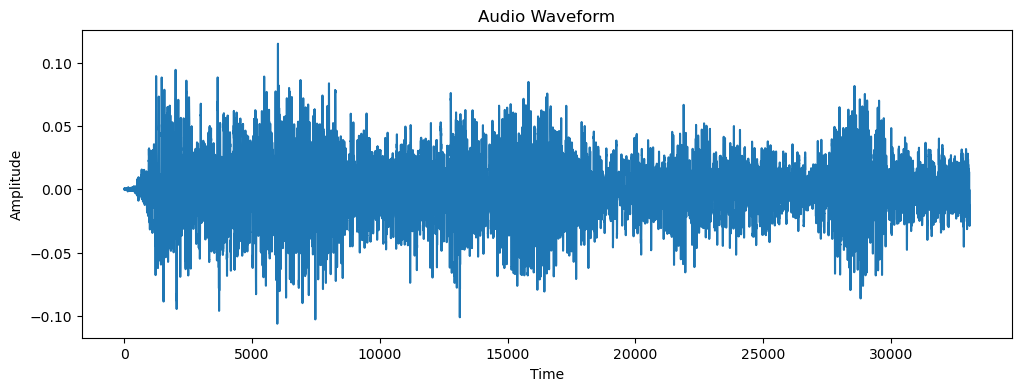

In [90]:
for i in range(num_samples_test):
    reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
    print(f"Original Signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f" Reconstructed signal")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

##### Conclusion:  Difficult to reconstruct a signal which was not part of train_set

### M4 Competition Dataset: Reconstruction, denoising, hyperparameters impact and "Forecasting"

In [4]:
Train_set = pd.read_csv("..\Dataset\Monthly_train.csv")

In [5]:
Train_set.shape

(48000, 2795)

In [4]:
Train_set.sample(5)

V1        V2       V3        V4        V5        V6       V7  \
38916  M38917  10200.00  10200.0  10200.00  10600.00  10600.00  10700.0   
16349  M16350    938.33    940.5    949.92    973.14    975.06    992.9   
13152  M13153   3110.00   3120.0   3180.00   3190.00   3050.00   3070.0   
30671  M30672   6600.00   6600.0   6600.00   6600.00   6200.00   6400.0   
41392  M41393   1600.00   1560.0   1560.00   1560.00   1560.00   1560.0   

             V8        V9       V10  ...  V2786  V2787  V2788  V2789  V2790  \
38916  10700.00  10700.00  10700.00  ...    NaN    NaN    NaN    NaN    NaN   
16349   1026.07   1028.06   1034.33  ...    NaN    NaN    NaN    NaN    NaN   
13152   3100.00   3000.00   3100.00  ...    NaN    NaN    NaN    NaN    NaN   
30671   6500.00   6600.00   6600.00  ...    NaN    NaN    NaN    NaN    NaN   
41392   1560.00   1560.00   1500.00  ...    NaN    NaN    NaN    NaN    NaN   

       V2791  V2792  V2793  V2794  V2795  
38916    NaN    NaN    NaN    NaN    NaN  
16349    NaN    NaN    NaN    NaN    NaN  
13152    NaN    NaN    NaN    NaN    NaN  
30671    NaN    NaN    NaN    NaN    NaN  
41392    NaN    NaN    NaN    NaN    NaN  

[5 rows x 2795 columns]

In [6]:
Train_set.dropna(axis=1, inplace= True)

In [7]:
Train_set.shape 

(48000, 43)

In [8]:
Train_set.drop("V1", inplace= True, axis= 1)

In [9]:
# Function to normalize each row
def normalize_row(row):
    scaler = StandardScaler()
    return scaler.fit_transform(row.values.reshape(-1, 1)).flatten()

In [10]:


# Apply the normalization to each row
Train_set = Train_set.apply(normalize_row, axis=1)

In [11]:
m = Train_set.shape[0]
train_set = np.zeros((m, 42))
for i in range(m):
    train_set[i,:] = Train_set[i]

In [12]:
train_set.shape

(48000, 42)

In [12]:
from sklearn.model_selection import train_test_split
from src.Evalution import Hyperparameter_analysis

In [13]:
# Generate a list of indices corresponding to the series
indices = np.arange(Train_set.shape[0])

# Split indices into training and testing sets
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Use the indices to create the training and testing sets
train = Train_set[train_indices]
test = Train_set[test_indices]

In [14]:
train.index = range(train.shape[0])

In [62]:
test.index = range(test.shape[0])

In [15]:
m = train.shape[0]
Train = np.zeros((m, 42))
for i in range(m):
    Train[i,:] = train[i]

In [63]:
m = test.shape[0]
Test = np.zeros((m, 42))
for i in range(m):
    Test[i,:] = test[i]

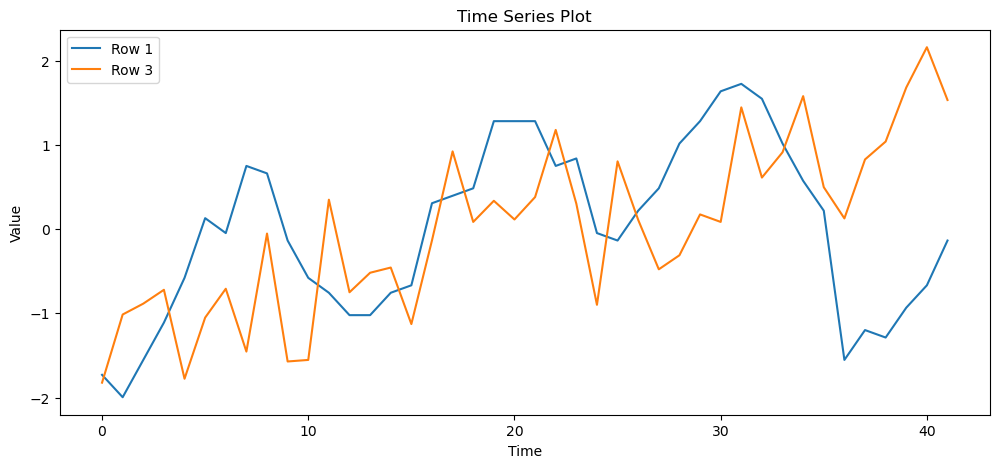

In [14]:
visualizer = TimeSeriesPlotter(Train)
visualizer.plot_indices([1, 3])

In [18]:
Train.shape

(38400, 42)

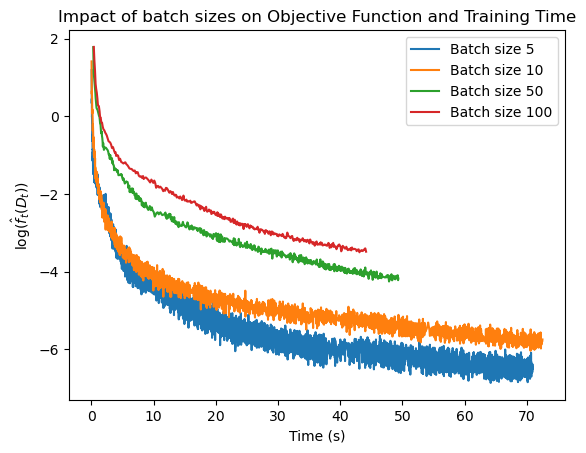

In [177]:
Hyperparameter_analysis.dictionary_learning_analysis_batch_sizes(Train, n_components = 10, 
                                                                 batch_sizes=[5, 10, 50, 100])

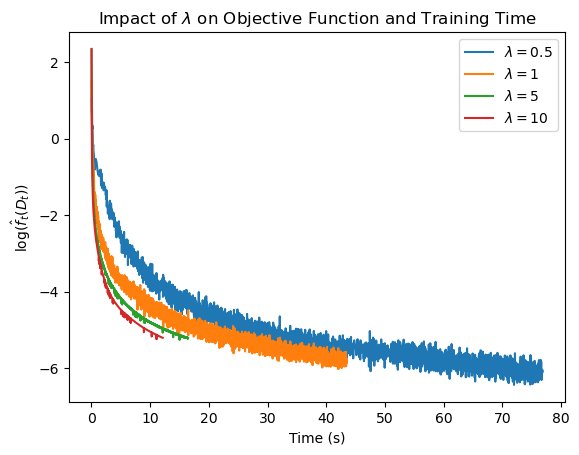

In [178]:
Hyperparameter_analysis.dictionary_learning_analysis_alphas(Train, n_components=10, 
                                                            batch_size=10, alphas=[0.5, 1, 5, 10])

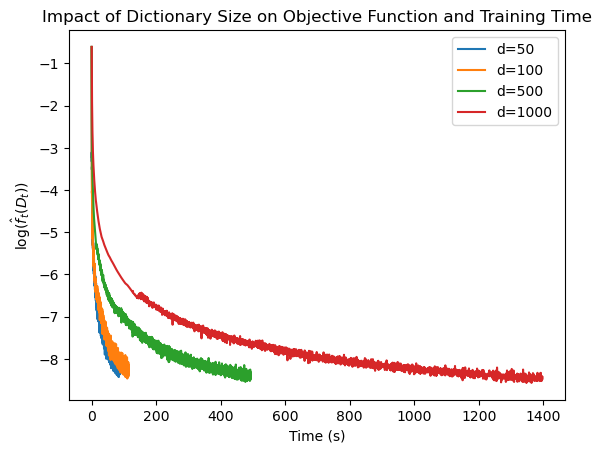

In [180]:
Hyperparameter_analysis.dictionary_learning_component_analysis(Train, batch_size=10, 
                                                               components_list=[50, 100, 500, 1000])

C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


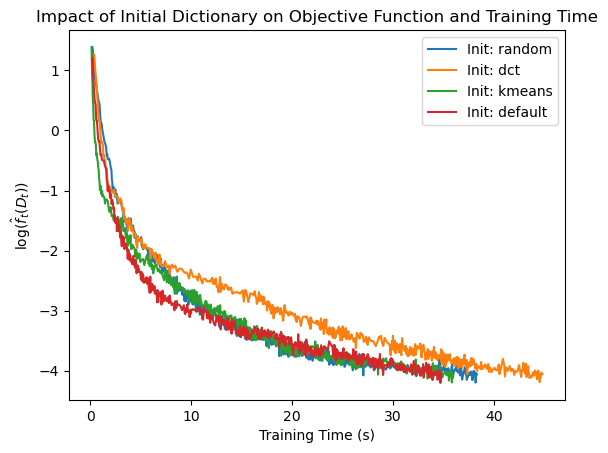

In [56]:
Hyperparameter_analysis.dictionary_learning_analysis_initial_dict(Train[:12000, :], n_components = 50, 
                                                                  batch_size = 20, alpha = 1, init_strategies = ["random", "dct", "kmeans", "default"])

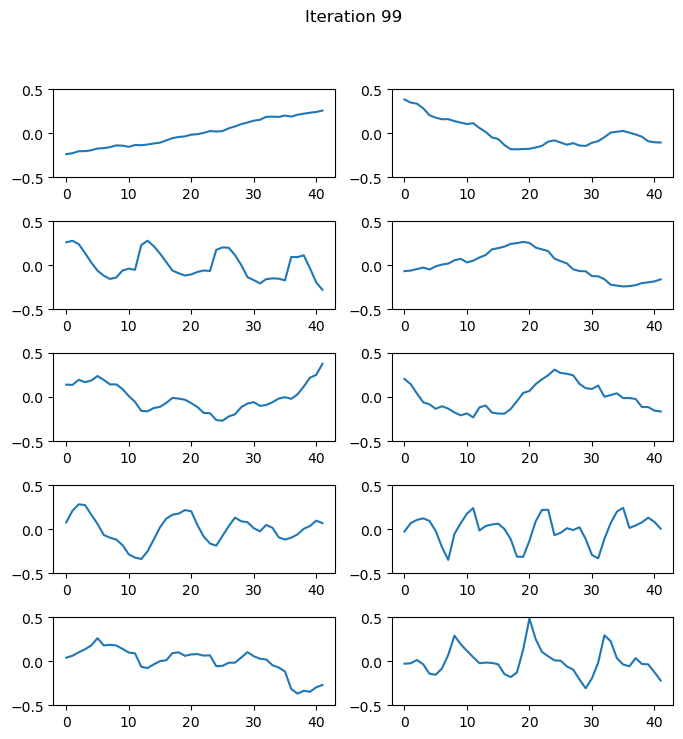

In [28]:
Hyperparameter_analysis.visualize_dictionary_evolution(Train[:1000,:], n_components= 10, batch_size=10)

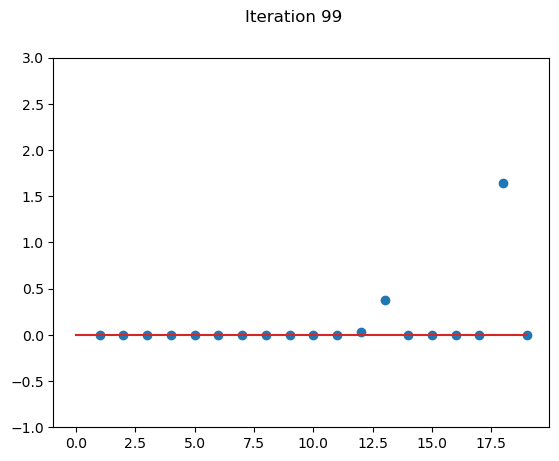

In [30]:
Hyperparameter_analysis.visualize_sample_evolution(Train[1: 1000,:], n_components=20, batch_size=10,
                                                   sample_every= 3, single_sample= Train[0,:])

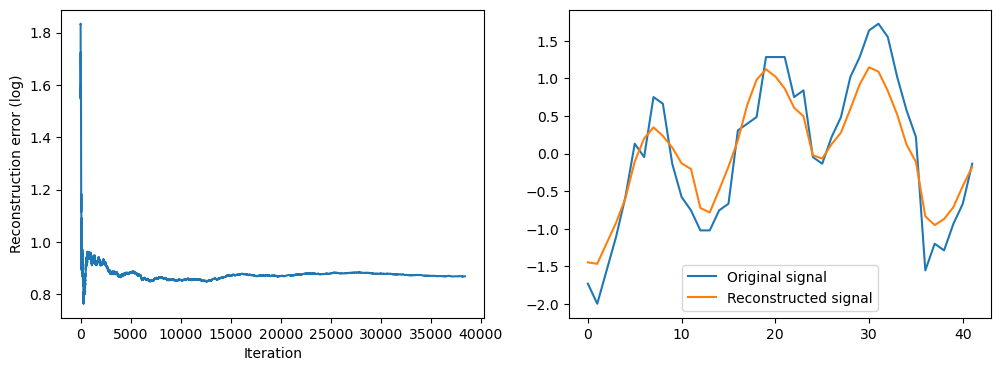

In [45]:
Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 5, batch_size=1, test_sample_index=1)

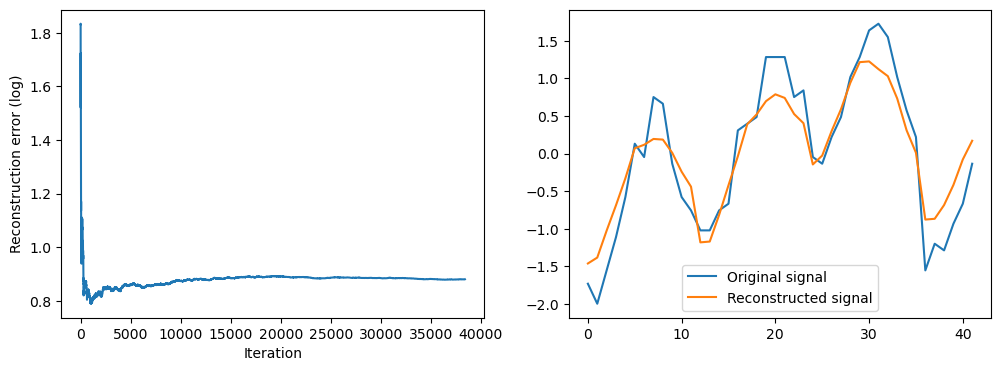

In [46]:

Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 10, batch_size=1, test_sample_index=1)

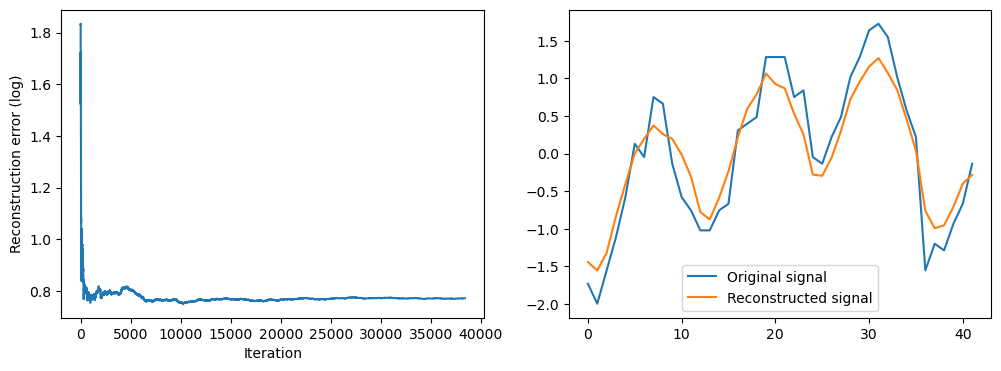

In [47]:
Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 50, batch_size=1, test_sample_index=1)

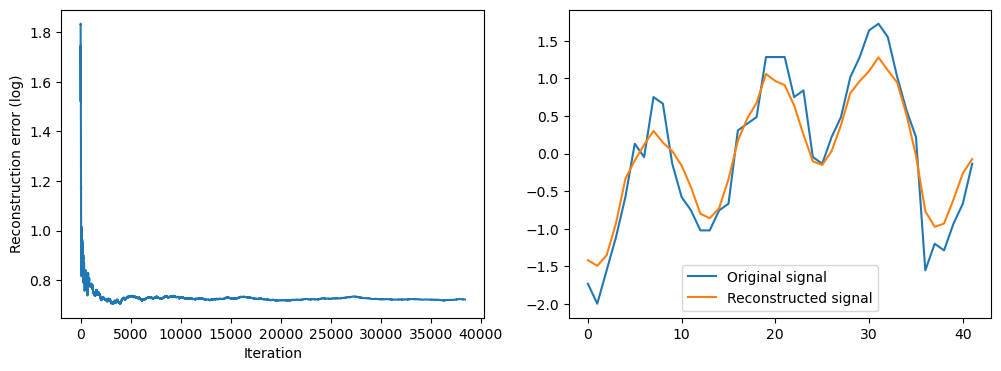

In [48]:
Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 100, batch_size=1, test_sample_index=1)

In [72]:
alpha = 1.2/np.sqrt(42)

In [74]:
n_components = [2, 5, 10, 15, 20, 50, 70, 100, 150, 200, 250, 500]
errors = []
for n in n_components:
    e = Hyperparameter_analysis.evaluate_reconstruction(Train, Test, n_components = n, batch_size = 10 , alpha = alpha)
    errors.append(e)

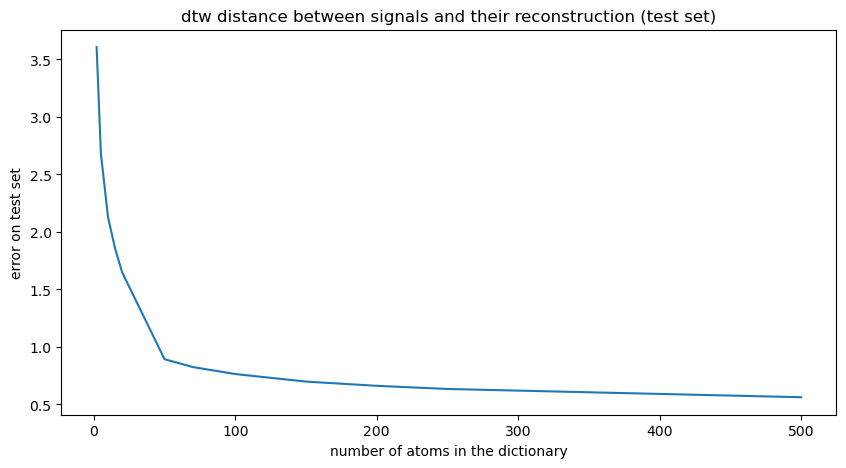

In [75]:
plt.figure(figsize = (10, 5))
plt.plot(n_components, errors)
plt.xlabel("number of atoms in the dictionary")
plt.ylabel("error on test set")
plt.title("dtw distance between signals and their reconstruction (test set)")
plt.show()

In [76]:
batch_size= [1, 5, 10, 15, 20, 50, 70, 100, 150, 200, 250,500]
errors = []
for n in batch_size:
    e = Hyperparameter_analysis.evaluate_reconstruction(Train, Test, n_components = 50, batch_size = n , alpha = alpha)
    errors.append(e)

C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.021e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 6.053e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.021e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.021e-02, with an active set o

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(n_components, errors)
plt.xlabel("batch size")
plt.ylabel("error on test set")
plt.title("dtw distance between signals and their reconstruction (test set)")
plt.show()

In [ ]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 1.8, 2, 5]
errors = []
for alpha in alphas:
    e = Hyperparameter_analysis.evaluate_reconstruction(Train, Test, n_components = 50, batch_size = 10 , alpha = alpha)
    errors.append(e)

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(alphas, errors)
plt.xlabel("batch size")
plt.ylabel("error on test set")
plt.title("dtw distance between signals and their reconstruction (test set)")
plt.show()